Dans les deux phases précédentes, nous avons récupéré des données provenant de plusieurs sources internet et nous les avons préparées pour la phase présente. 

# Apprentissage

**Dans cette partie, nous allons essayer de développer un modèle qui prédise avec le moins d'écart avec la réalité possible le revenu moyen dans un département.**

On commence par importer toutes les libraries et fonctions nécéssaires à notre analyse.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import script as sc
plt.rcParams["figure.figsize"] = (6,6)

In [2]:
from script import outliers, multiplot2, analyse, verif_overfitting, verif_apprentissage, metriques, valeurs_predites, coefficients

In [3]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoLars

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

On s'aidera uniquement de la librairie ScikitLearn qui fournit des outils très performants et ergonomiques pour le machine learning. On importe également notre jeu de données sous le nom de data.

In [4]:
data = pd.read_csv("df_final.csv")

La variable à expliquer est le revenu moyen ($y$ un vecteur de dimension $n\times 1$). On se sert des autres variables pour réaliser les prédictions ($X$ une matrice de dimension $n\times p$). 

In [5]:
data=data.set_index('departement')
X=['pop_2018' , 'densite', 'pop_municipale', 'hab_m', 'pib_2000', 'décla','impot']
y=['revenu_moyen']
data

,pop_2018,densite,pop_municipale,hab_m,pib_2000,décla,impot,revenu_moyen
departement,,,,,,,,
I s è r e,1.284619,0.800611,1.242093,0.744711,0.865181,1.506494,0.645272,1.056381
A u b e,-0.443752,-0.294850,-0.450764,-0.368124,0.272874,-0.207792,0.356447,-0.085534
P u y - d e - D ô m e,0.182451,-0.013512,0.165045,0.090268,0.616706,0.627706,0.175358,0.312981
V a l - d e - M a r n e,1.520007,51.993985,1.462224,19.148801,1.203286,2.948052,2.720917,1.806381
E u r e - e t - L o i r,-0.219279,-0.090787,-0.215903,-0.107898,0.107556,0.735931,0.182235,0.517327
...,...,...,...,...,...,...,...,...
A r d e n n e s,-0.510141,-0.288464,-0.489568,-0.432299,-0.378439,-0.086580,-0.287679,-0.668042
P a r i s,2.976740,190.981537,3.164478,1585.861072,11.838666,7.515152,10.373639,6.426018
M a y e n n e,-0.448443,-0.222849,-0.445127,-0.033850,0.334869,-0.445887,-0.642980,-0.030253


Les données sont bien celles que nous avons enregistrées à l'étape précédente dans la phase de preprocessing. 

Comme on l'a vu précédemment, il y a une variable abérrante au niveau du nombre d'habitant par mètre carré sur la ville de Paris. Pour faciliter les estimations, on se débarrasse de cette donnée. 

In [6]:
data=(
    data
    .pipe(sc.outliers)
)

Comme dit précédemment, nous avons une variable dépendante $y$ quantitative et continue. Toutes nos variables explicatives $X$ sont quantitatives également. Nous avons peu de données et elles sont structurées et normales. Il existe des points extrêmes dans notre échantillon et certaines de nos variables sont corrélées.

Nous allons donc naturellement nous orienter vers des méthodes de régression, plutôt simples. 

## Réalisation de plusieurs modèles 

Dans le but de choisir le meilleur modèle de prédiction, on réalise plusieurs modèles et on observe certaines métriques. On commence par des régressions simples pour aller vers des méthodes ensemblistes plus complexes. On propose donc plusieurs modèles qu'on essaye de tuner grâce à GridSearchCV  et dont on peut observer certaines métriques. Les modèles sont optimisés selon la métrique de la moyenne de l'erreur absolue. On choisit ce critère car on décide de chercher le modèle qui minimise l'écart entre les prédictions et la vraie valeur du revenu moyen par département. Plus précisément, on cherche à élaborer un modèle avec une moyenne des erreurs au carré inférieure à 0,3 et un R2 supérieur à 0,5.

La procédure est la suivante, on divise notre base de données en deux échantillons : un échantillon de test et un échantillon d'apprentissage (2/3 des données soit environ 60 individus). Ensuite, selon le modèle, on propose un dictionnaire d'hyperparamètres qui sera utilisé pour chercher le meilleur modèle parmi toutes les combinaisons d'hyperparamètres. Comme dit précédemment, on optimise les modèles grâce à GridSearchCV selon le critère de la moyenne de l'erreur absolue que l'on peut définir de la sorte : 
$$ NMAE(y, \hat{y})=- \frac{1}{n}\sum_{i=1}^{n}|y_{i}-\hat{y}_{i}|$$

Le modèle optimal est le modèle dont la combinaisaon d'hyperparamètres permet d'obtenir la plus petite valeur de la MAE. Le modèle sera ensuite entraîné et on observe plusieurs autres métriques :
* NMSE : La moyenne des écarts au carré dont la formule est :
$$ NMSE(y, \hat{y})=- \frac{1}{n}\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2$$

* MaxError : L'erreur maximale qui est l'erreur maximale commise par le modèle entre $y_i$ et $\hat{y}_i$.

* R2 : Le coefficient de déterminantion nous donne une indication de l'adaptation du modèle au données. Il peut être trompeur car un R2 très élevé peut être un indicateur de surapprentissage et donc synonyme de très mauvaises prédictions sur les données test. Sa formule est la suivante : 
$$R2(y, \hat{y})=1-\frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2}{\sum_{i=1}^{n}(y_{i}-\bar{y}_{i})^2}$$


Enfin, toutes les métriques sont obtenues à partir de la fonction cross_val_score de sklearn avec 2 validations croisées. Les métriques obtenues ultérieurement seront donc des moyennes.

### Régression linéaire ou polynomiale

Le premier modèle testé est le plus simple. La régression tente de trouver des coefficients tels que
$y=f(X)$. Plus précisément, on cherche les $\beta_i$ tels que $$y=\alpha + \beta_1 X_1 ... + \beta_n X_n +\epsilon$$ où $n$ est le nombre de variables, $\alpha$ la constante et $\epsilon$ l'erreur du modèle. On cherche à minimiser $\epsilon$. La fonction utilisée pour cela est LinearRegression de Sklearn.

Afin de tester si notre modèle est plus polynomial que linéaire, nous créons un Pipeline qui sera passé dans la fonction GridSearchCV et qui fonctionne en créant d'abord des versions polynomiales de nos variables (avec interactions) avant de les estimer par la fonction LinearRegression :
`` " Pipeline([('scaler', PolynomialFeatures()), ('lin_reg', LinearRegression())]) " ``


Les paramètres testés par GridSearchCV sont :

``param_grid={'scaler__interaction_only':['False','True'],
           'scaler__degree':[1, 2],
           'lin_reg__normalize':['False','True'],
           'scaler__include_bias':['False','True'],
           'lin_reg__fit_intercept':['False', 'True']}``
           
On lance notre fonction d'analyse qui nous permet de stocker le meilleur modèle, les meilleurs hyperparamètres, le meilleur score, les résidus ($\epsilon$) et le meilleur score sur les données d'entraînement.

In [7]:
mod_linreg, best_para_linreg, best_score_linreg, resid_linreg, score_tr_linreg = analyse('Lin_reg', data)

NMSE : -0.4961859977838066
MaxErr : -2.104349955890469
R2 : 0.5417844488555927
NMAE : -0.24805443260748067
Somme des résidus : [1.98729921e-14]
Moyenne des résidus : 3.090120751873352e-16


In [8]:
best_para_linreg

{'lin_reg__fit_intercept': 'False',
 'lin_reg__normalize': 'False',
 'scaler__degree': 1,
 'scaler__include_bias': 'False',
 'scaler__interaction_only': 'False'}

### Régression Ridge

Nous passons maintenant à une regression Ridge qui est une régression linéaire avec une contrainte quadratique sur les coefficients, fréquemment utilisée quand les variables sont très corrélées. L'expression numérique du problème d'optimisation peut s'écrire de la sorte : 
$$min_{\beta} E(\alpha, \beta)=\sum_{i=1}^{n}(y_{i}-X_{i}\beta)^{2}+\alpha||\beta||^2$$

La contrainte sur les coefficients augmente l'erreur sur la base d'apprentissage et réduit la norme des coefficients, ce qui peut nécessiter la normalisation des données avant traitement. 

Ce modèle peut nous être utile dans la mesure où nous avons des variables asssez corrélées comme les variables de population (*pop_2018, densite, pop_municipale*). Par contre, nous ne sommes pas dans le cas d'un grand nombre de variables. 

Nous testons les hyperparamètres suivants dans la fonction GridSearchCV :

``param_grid2={'alpha':[0.01, 0.05, 0.1, 0.5, 1],
              'fit_intercept': ['True',  'False'],
              'normalize': ['True',  'False'],
              'copy_X': ['True',  'False'],
              'max_iter':[500, 1000, 1500],
              'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}``

On lance notre fonction d'analyse qui nous permet de stocker le meilleur modèle, les meilleurs hyperparamètres, le meilleur score, les résidus ($\epsilon$) et le meilleur score sur les données d'entraînement.

In [9]:
mod_ridge,best_para_ridge, best_score_ridge, resid_ridge, score_tr_ridge = analyse('Ridge', data)

NMSE : -0.3072032161503269
MaxErr : -1.4047415174971167
R2 : 0.7412750814215582
NMAE : -0.24978774073496587
Somme des résidus : [2.3869795e-15]
Moyenne des résidus : 2.8680761469483214e-17


In [10]:
best_para_ridge

{'alpha': 0.01,
 'copy_X': 'False',
 'fit_intercept': 'True',
 'max_iter': 500,
 'normalize': 'False',
 'solver': 'saga'}

### Régression Lasso

Dans la régression Lasso, les coefficients sont obtenus en minimisant la somme des carrés des résidus mais avec une contrainte en plus. Le problème de minimisation s'écrit comme cela :
$$ min_{\beta_1...\beta_p}\frac{1}{2}\sum_{i=1}^{n}\bigg(y_i-\beta_{0}-\sum_{j=1}^{p}\beta_{j}x_{i,j}\bigg)$$ 
sous la contrainte $\sum_{j=1}^{p}|\beta_j|\leq t$. Le paramètre $t$ contrôle donc le niveau de régularisation des coefficients estimés. Il est possible que les coefficients associés à certaines variables soient nuls. 

Un problème que nous pouvons rencontrer survient dans le cas de très grande corrélation : si des variables sont fortement corrélées et qu'elles sont importantes pour la prédiction, le Lasso aura tendance à en privilégier une au détriment des autres. 

Les hyperparamètres testés par GridSearchCV sont : 
    
``param_grid3={'fit_intercept':['False','True'],
           'alpha':[0.01, 0.05, 0.1, 0.5, 1],
           'normalize':['False','True'],
           'positive':['False', 'True'],
           'random_state':[0],
           'selection':['cyclic', 'random'],
           'copy_X':['False','True'],
           'warm_start':['False','True']}``

On lance notre fonction d'analyse qui nous permet de stocker le meilleur modèle, les meilleurs hyperparamètres, le meilleur score, les résidus ($\epsilon$) et le meilleur score sur les données d'entraînement.

In [11]:
mod_lasso, best_para_lasso, best_score_lasso, resid_lasso, score_tr_lasso=analyse('Lasso', data)

NMSE : -0.20971284846107646
MaxErr : -1.3676614506514244
R2 : 0.6968873327259001
NMAE : -0.3024163794534596
Somme des résidus : [1.99840144e-15]
Moyenne des résidus : 3.3306690738754695e-17


In [12]:
best_para_lasso

{'alpha': 0.01,
 'copy_X': 'False',
 'fit_intercept': 'False',
 'normalize': 'False',
 'positive': 'False',
 'random_state': 0,
 'selection': 'random',
 'warm_start': 'False'}

On peut également tester une extension de la méthode Lasso avec la commande LassoLars qui implémente une résolution Lasso en faisant appel à l'algorithme LARS (pour least-angle regression).

In [13]:
mod_lassoLars, best_para_lassoLars, best_score_lassoLars, resid_lassoLars, score_tr_lassoLars=analyse('LassoLars', data)

NMSE : -0.3326891575780464
MaxErr : -1.6590752741737673
R2 : 0.6333862398102341
NMAE : -0.30099244658326796
Somme des résidus : [-0.30984795]
Moyenne des résidus : -0.005164132568884554


In [14]:
best_para_lassoLars

{'alpha': 0.01,
 'copy_X': 'False',
 'fit_intercept': 'False',
 'fit_path': 'False',
 'jitter': 0.01,
 'max_iter': 1000,
 'normalize': 'True',
 'random_state': 0}

### Méthodes ensemblistes 

Les méthodes testées dans cette partie sont beacoup plus complexes que les précédentes. En effet, elles font appel à des techniques plus sophistiquées que la simple régression. L'idée générale est de faire appel à plusieurs estimateurs et de combiner leurs résultats afin d'obtenir le meilleur estimateur.

Outre la complexité inhérente à ces méthodes, une autre problématique se pose : celle du surapprentissage. Ces modèles dont donc assez compliqués à paramétrer et peuvent cependant fournir des résultats médiocres. Sur des données simples et peu nombreuses comme les nôtres, on a tendance à penser que ce ne sont pas les méthodes les plus pertinentes. Nous allons cependant en tester quelques unes. 

#### Forêt aléatoire

La principe de la forêt aléatoire est de regrouper plusieurs arbres de décision. Le problème des arbres de décision est qu'ils sont très soumis au surapprentissage. La forêt aléatoire, quant à elle n'est pas susceptble d'être en surapprentissage et elle combine plusieurs arbres de décision peu voire pas profonds.

Les paramètres testés par GridSearchCV sont les suivants :
    
``param_grid6={'n_estimators': [5, 8, 10, 25, 50],
          'max_depth': [2, 3, 4],
          'max_features':[2, 'auto', 'sqrt', 'log2'],
          'min_samples_split': [2, 3, 4],
          'bootstrap': ['True', 'False'],
          'max_samples':[2, 3, 4],
          'warm_start':['False','True']}``
      
On lance la fonction analyse et on peut observer les résultats. Pour réduire le temps d'éxécution de ce modèle, les métriques ne seront pas obtenues par CrossValidation. 

In [15]:
mod_RandF, best_para_RandF, best_score_RandF, resid_RandF, score_tr_RandF=analyse('RandF', data)

NMAE : -0.45511056105610576
NMSE : 0.7687840085424935
R2 : 0.40653190577325105
MaxError : 4.784279427942795
Somme des résidus : [8.5139604]
Moyenne des résidus : 0.1418993399339934


In [16]:
best_para_RandF

{'bootstrap': 'True',
 'max_depth': 3,
 'max_features': 2,
 'max_samples': 4,
 'min_samples_split': 2,
 'n_estimators': 50,
 'warm_start': 'True'}

#### AdaBoost

L'algorithme Adaboost permet de combiner plusieurs estimateurs faibles et d'en "booster" les performances. Cet algorithme peut se baser sur plusieurs autres modèles comme les arbres de décision par exemple. Chaque estimateur faible réalise un apprentissage sur les données en corrigeant les erreurs des estimateurs précédents. Les sorties des autres algorithmes sont combinées en une somme pondérée qui représente la sortie finale du régresseur boosté.

Les hyperparamètres testés par GridSearchCV sont :
    
``param_grid7={'n_estimators': [5, 8, 10, 25, 50],
          'base_estimator':[DecisionTreeRegressor(), LinearRegression()],
          'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
          'loss':['linear', 'square', 'exponential']}``
          
Cet algorithme va donc être testé sur la régression linéaire et l'arbre de décision. On lance la commande analyse et on peut observer certaines métriques.

In [18]:
mod_AdaBoost, best_para_AdaBoost, best_score_AdaBoost, resid_AdaBoost, score_tr_AdaBoost=analyse('AdaBoost', data)

NMSE : -1.3089308966902775
MaxErr : -3.2755852898891638
R2 : 0.31118054461278294
NMAE : -0.2423672381291246
Somme des résidus : [-0.22759765]
Moyenne des résidus : -0.0037932941148013117


In [19]:
best_para_AdaBoost

{'base_estimator': LinearRegression(),
 'learning_rate': 0.05,
 'loss': 'linear',
 'n_estimators': 50}

#### Bagging

La technique de bagging est un estimateur ensembliste qui permet d'entraîner plusieurs modèles faibles sur plusieurs échantillons des données originelles et d'en aggréger les prédictions individuelles pour former une prédiction finale. Comme pour le boosting, cet algorithme peut se baser sur d'autres estimateurs faibles comme les arbres de décision. 

Les hyperparamètres tunés par GridSearchCV sont les suivants :

``param_grid8={'warm_start': ['False', 'True'],
          'base_estimator':[DecisionTreeRegressor(), LinearRegression()],
          'n_estimators':[5, 8, 10, 25, 50],
          'bootstrap':['True', 'False'],
          'max_features': [0.5, 1],
          'n_jobs':[1, 2, 3],
          'random_state':[0]}``
          
Comme pour le modèle précédent, on définit que les estimateurs faibles peuvent être des régressions linéaires ou des arbres de décision. On lance la fonction analyse et on peut observer les résultats. Pour réduire le temps d'éxécution de ce modèle, les métriques ne seront pas obtenues par CrossValidation.

In [20]:
mod_Bagging, best_para_Bagging, best_score_Bagging, resid_Bagging, score_tr_Bagging=analyse('Bagging', data)

NMSE : 0.12020190654436558
R2 : 0.9072093128802855
MaxError : 1.215784814693079
Somme des résidus : [-0.38810884]
Moyenne des résidus : -0.006468480715075011


In [21]:
best_para_Bagging

{'base_estimator': LinearRegression(),
 'bootstrap': 'True',
 'max_features': 0.5,
 'n_estimators': 25,
 'n_jobs': 1,
 'random_state': 0,
 'warm_start': 'False'}

On peut conclure que les modèles les plus simples ne sont pas forcément les plus mauvais. Parmis les modèles qui obtiennent les meilleures métriques, on a les régressions Ridge et Lasso et le bagging avec la regression linéaire comme estimateur de base. Le bagging semble être un estimateur très complexe pour si peu de données. De plus, ce R2 très élevé peut être signe d'overfitting. 

## Choix du meilleur modèle 

Nous allons observer quelques graphiques afin de valider notre choix de modèle final.

### Overfitting

On essaye de checker le surapprentissage dans les modèles Ridge, Lasso et Bagging. On utilise pour cela la fonction validation_curve avec cinq validations croisées. Si la courbe correspondant au score d'entraînement et celle correspondant au score de validation sont toutes les deux basses, alors l'estimateur est en sous-apprentissage. Si le score d'apprentissage est très haut et le score de validation est bas, alors on en en situation de surapprentissage, sinon, c'est que le modèle marche bien. La métrique considérée est la moyenne des erreurs absolues.

#### Régression Lasso

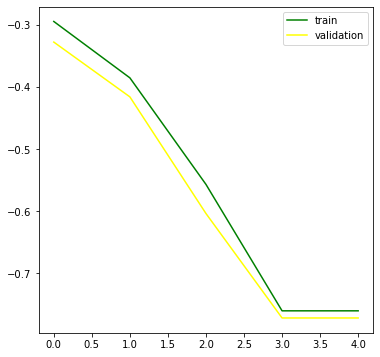

In [22]:
train_scores_lasso, valid_scores_lasso =verif_overfitting('Lasso', mod_lasso.best_estimator_, data)

On voit qu'il y a un peu d'overfitting mais cela est constant et le delta entre le score entraînement et le score de validation est réduit.

#### Bagging

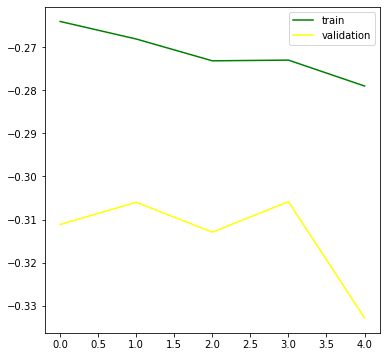

In [23]:
train_scores_bagging, valid_scores_bagging = verif_overfitting('Bagging', mod_Bagging.best_estimator_, data)

Sans surprise, on observe qu'il y a de l'overfitting mais pas tant que cela. 

#### Régression Ridge

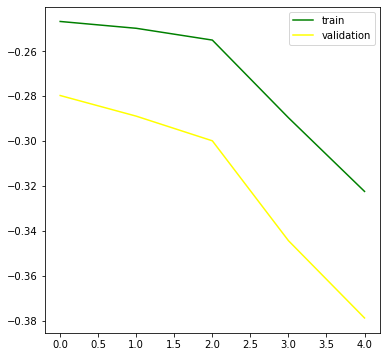

In [24]:
train_scores_ridge, valid_scores_ridge =verif_overfitting('Ridge', mod_ridge.best_estimator_, data)

Dans ce cas, il y a un peu d'overfitting. Ce modèle semble être le meilleur car il présente la MAE la plus faible sur les données de test.

### Courbe d'apprentissage

Dans cette partie, nous cherchons à savoir si notre modèle pourrait être plus performant s'il bénéficiait de plus de données. Si les courbes sont dans une phase de croissance, alors cela peut être le signe que le modèle aurait pu être plus efficace avec plus de données. La métrique considérée est la moyenne des erreurs absolues.

#### Régression Lasso

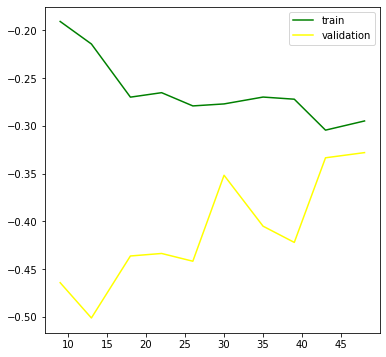

In [25]:
train_sizes_lasso2, train_scores_lasso2, valid_scores_lasso2=verif_apprentissage('Lasso', mod_lasso.best_estimator_, data)

La courbe sur les données d'entraînement est assez stable, voire décroissante. On a des scores encore croissants en échantillon de validation donc effectivement, notre modèle gagnerait à être plus performant avec plus de données.

#### Bagging

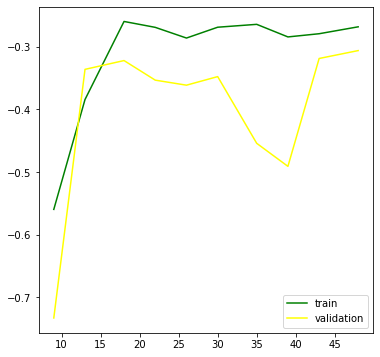

In [26]:
train_sizes_bagging2, train_scores_bagging2, valid_scores_bagging2=verif_apprentissage('Bagging', mod_Bagging.best_estimator_, data)

Sans surprise, ce modèle pourrait être plus performant avec plus de données.

#### Régression Ridge

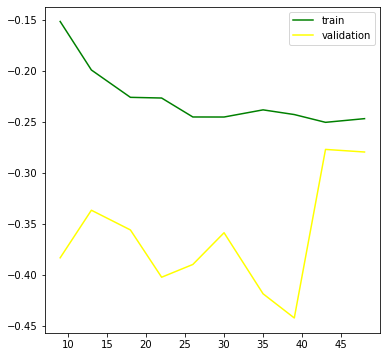

In [27]:
train_sizes_ridge2, train_scores_ridge2, valid_scores_ridge2=verif_apprentissage('Ridge', mod_ridge.best_estimator_, data)

La courbe sur les données d'entraînement est assez stable, voire décroissante. On a des scores encore croissants en échantillon de validation donc effectivement, notre modèle gagnerait à être plus performant avec plus de données. C'est à peu près le même cas que pour la régression lasso avec une MAE plus faible cependant.

La régression Ridge semble être le meilleur modèle. Elle présente des métriques intéressantes. On arrête donc notre choix sur ce modèle. Nous allons enchaîner sur les prédictons sur les données de test et l'observation de certaines métriques sur ces mêmes données.

## Prédictions 

On a donc choisi le modèle Ridge comme meilleur modèle. On va réaliser les prévisions mais on commence par observer les coefficients associés à chaque variable.

In [28]:
X=['pop_2018' , 'densite', 'pop_municipale', 'hab_m', 'pib_2000', 'décla','impot']
y=['revenu_moyen']
X_train, X_test, y_train, y_test = train_test_split(data[X], data[y], test_size=0.33, random_state=42)

In [29]:
coefficients(X_train, mod_ridge)

COEFFICIENTS DE CHAQUE FEATURE
pop_2018 : 0.06577651159871525
densite : -0.011316956809945244
pop_municipale : 0.03199110927586679
hab_m : -0.024539857490564712
pib_2000 : 0.17040738486517887
décla : 0.2500949236657729
impot : 0.5085328224274448


Les coefficients sont très petits du fait de la contrainte quadratique appliquée sur ces derniers par la régression Ridge. Les plus importants sont *impot*, *décla* et *pib_2000*.

In [30]:
revenu_moyen_prédit= mod_ridge.best_estimator_.predict(X_test)
array_test=np.array(y_test)

On peut finalement observer les métriques sur les données de test afin de savoir si elles correspondent à nos attentes. 

In [31]:
metriques(y_test, revenu_moyen_prédit)

METRIQUES SUR LES DONNEES DE TEST
MSE : 0.28139
R2 : 0.53703
MaxError : 2.26719
MAE : 0.31427


In [32]:
resid=[]
for i in range(len(y_test)):
            residuals=np.abs(array_test[i])-np.abs(revenu_moyen_prédit[i])
            resid.append(np.round(np.asarray(residuals),6))

On réalise les prédictions et on observe les valeurs prédites et les valeurs réelles du revenu moyen. 

In [33]:
y_test['predit']=revenu_moyen_prédit
y_test['erreur']=np.asarray(resid)
y_test

,revenu_moyen,predit,erreur
departement,,,
L o t - e t - G a r o n n e,-0.536029,-0.384618,0.151411
A l l i e r,-0.630638,-0.458794,0.171844
S a ô n e - e t - L o i r e,-0.008801,-0.100488,-0.091687
A v e y r o n,-0.202420,-0.438016,-0.235595
I s è r e,1.056381,0.990224,0.066156
Y o n n e,-0.224422,-0.114913,0.109509
F i n i s t è r e,0.327283,0.026684,0.300599
M e u r t h e - e t - M o s e l l e,0.239274,0.386557,-0.147284
L o i r e,-0.015127,-0.015245,-0.000119


L'erreur maximale est commise pour le département suivant. 

In [34]:
y_test[ y_test['erreur'] == y_test['erreur'].max() ]

,revenu_moyen,predit,erreur
departement,,,
H a u t e - S a v o i e,3.234873,0.967682,2.267192


Cette erreur très imporatante peut être expliquée par le fait que le modèle ne prenne pas en compte le caractère frontalier avec la Suisse de ce département.

Pour finir, on peut observer le département pour lequel le salaire moyen prédit est le plus élevé sur les données test.

In [35]:
y_test[ y_test['predit'] == y_test['predit'].max() ]

,revenu_moyen,predit,erreur
departement,,,
V a l - d ' O i s e,1.00385,1.318698,-0.314847


## Récapitulatif sur les données 

Le modèle nous permet de conclure que le département dont on prévoit qu'il aura le revenu moyen le plus élevé est le suivant.

In [36]:
data['predit']=mod_ridge.best_estimator_.predict(data[X])
data[ data['predit'] == data['predit'].max() ]

,pop_2018,densite,pop_municipale,hab_m,pib_2000,décla,impot,revenu_moyen,predit
departement,,,,,,,,,
H a u t s - d e - S e i n e,1.923323,84.365462,1.922821,30.119887,10.529566,6.987013,7.40745,5.783828,5.843772


## Réponse à la problématique

Au cours de notre étude, nous avons donc commencé par réaliser un web scraping des données sur diverses pages web et les avons condensées en un data frame. Par la suite, nous avons traité le data frame afin de le rendre exploitable. Nous avons terminé par réaliser la phase de machine learning au cours de laquelle nous avons entraîné plusieurs modèles sur nos données afin de trouver le plus performant. 

Pour conclure, on peut dire que c'est le modèle Ridge qui semble être le meilleur. Sur nos données test, nous obtenons une moyenne des erreurs au carré de : 0,28 inférieure à 0,3 et un R2 de : 0,54 donc supérieur à 0,5 ce qui répond à nos objectifs.

Selon le modèle, les coefficients les plus significatifs sont le montant des impôts et le revenu déclaré et sont tous les deux positifs. Cela semble assez logique. Les variables *densite* et *hab_m* semblent avoir un très léger effet négatif sur la valeur du revenu moyen. 

Selon notre modèle, le département qui fournit le plus haut salaire moyen est le département des Hauts-de-Seine. Globalement, on comprend bien que la région parisienne dans son ensemble fournit les meilleurs salaires car le niveau des prix est plus élevé qu'ailleurs en France. 

On peut mettre en lumière quelques unes des faiblesses de notre étude. D'abord, nous avons très peu de données. Nous avons malheureusement été amenés à renoncer à certaines données au cours de la phase de web scraping puis au cours de la phase d'unification des diverses sources. De plus, les disparités économiques géographiques qui existent en France se font sentir dans nos analyses. La complexité du cas parisien n'a pas pu être prise en compte dans notre étude car Paris est un département trop particulier par rapport aux autres de telle sorte que l'intégrer à notre étude démultiplierait les erreurs. De même, le caractère frontalier de certains département n'est pas pris en compte. 

En guise d'ouverture, on peut proposer de tenter de répondre à la même problématique mais cette fois-ci dans plusieurs villes de France. Cela nous permettrait d'avoir une base de données plus conséquente et cela pourrait réduire l'effet que les inégalités géographiques exercent sur notre étude.